# Credit Card Fraud Detection with Machine Learning Models

## Ian Heung

In this project, I will use a dataset from Kaggle and develop machine learning models to determine whether a transaction is fraudulent or not. The dataset is highly unbalanced, with the number of fraud cases only accounting for **only 0.172%** of transactions. I will navigate the challenge of the class imbalance in the dataset and develop machine learning models for accurate classification of the transactions.

## Data Overview

The dataset composes of credit card transactions made by European cardholders during September 2013, spanning a period of two days. There are 492 fraud cases out of a total of 284,807 transactions. This dataset is heavily imbalanced, with the positive class (fraud cases) comprising only 0.172% of all transactions.

With the expection of Time and Amount, all input variables have undergone a Principal Component Analysis (PCA) transformation to protect confidentiality. As a result, the original features and further background details are not included. 

Key aspects of the dataset are as follows:

- Features V1 through V28 represent the principal components derived via PCA.
- Two features, Time and Amount, remain untransformed. Time represents the seconds that have elapsed since the first transaction, and Amount reflects the transaction value, which may be useful for implementing cost-sensitive learning models.
- The target variable, Class, indicates whether a transaction is fraudulent (1) or not (0).

## Objectives
- Explore and understand the dataset given the limited information we have about the PCA transformed features
- Formulate solutions and workarounds to the class imbalance problem
- Use various model solutions and architectures and evaluate which best fits our usecase
- Determine the appropriate evaluation metrics

In [1]:
# imports
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
from datetime import datetime

#import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
#from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import NearMiss
#from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

## Data Exploration

#### Preliminary Data Exploration

Lets conduct an initial glimpse of our data

In [2]:
filepath = 'creditcard.csv' # change filepath accordingly 
df = pd.read_csv(filepath)
df.head() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
df.isnull().sum().sum()

0

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
num_non_fraud = df['Class'].value_counts()[0] # number of non-fraudulent transactions
num_fraud = df['Class'].value_counts()[1] # number of fraudulent transactions
no_fraud_percent = round(df['Class'].value_counts()[0]/len(df) * 100,2) # percentage of non-fraudulent transactions
fraud_percent = round(df['Class'].value_counts()[1]/len(df) * 100,2) # percentage of fraudulent transactions

print('No Frauds: ',num_non_fraud , f'({no_fraud_percent}%)')
print('Frauds: ', num_fraud, f'({fraud_percent}%)')

No Frauds:  284315 (99.83%)
Frauds:  492 (0.17%)


#### Visualizations
As mentioned earlier, our dataset is very imbalanced. Most transactions are non-fraud, while only **0.17%** of the data is fraudulent. Thinking ahead about our classification models, we need to figure out a way to deal with this imbalance to prevent model overfitting. We can also visualize how imbalanced the data actually is.

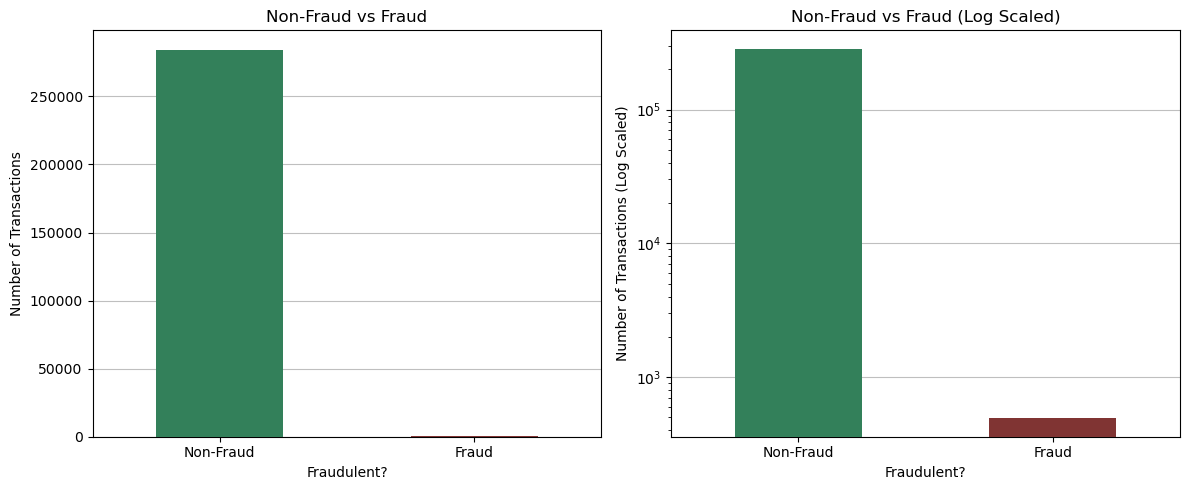

In [7]:
class_counts = df['Class'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax1 = class_counts.plot(kind='bar', ax=axes[0], color=['#33805a', '#803433'], zorder=3)
ax1.grid(color='gray', axis='y', alpha=0.5, zorder=1)
ax1.set_xticklabels(['Non-Fraud', 'Fraud'])
ax1.set_title('Non-Fraud vs Fraud')
ax1.set_xlabel('Fraudulent?')
ax1.set_ylabel('Number of Transactions')
ax1.set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

ax2 = class_counts.plot(kind='bar', ax=axes[1], color=['#33805a', '#803433'], zorder=3, logy=True)
ax2.grid(color='gray', axis='y', alpha=0.5, zorder=1)
ax2.set_xticklabels(['Non-Fraud', 'Fraud'])
ax2.set_title('Non-Fraud vs Fraud (Log Scaled)')
ax2.set_xlabel('Fraudulent?')
ax2.set_ylabel('Number of Transactions (Log Scaled)')
ax2.set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

plt.tight_layout()

plt.show()


We see even in the log scaled plot, the number of non-fraud cases still overwhelmingly outnumbers the number of fraud cases.

Lets now see histogram distributions of the time and transaction amount values to see the data spread. 

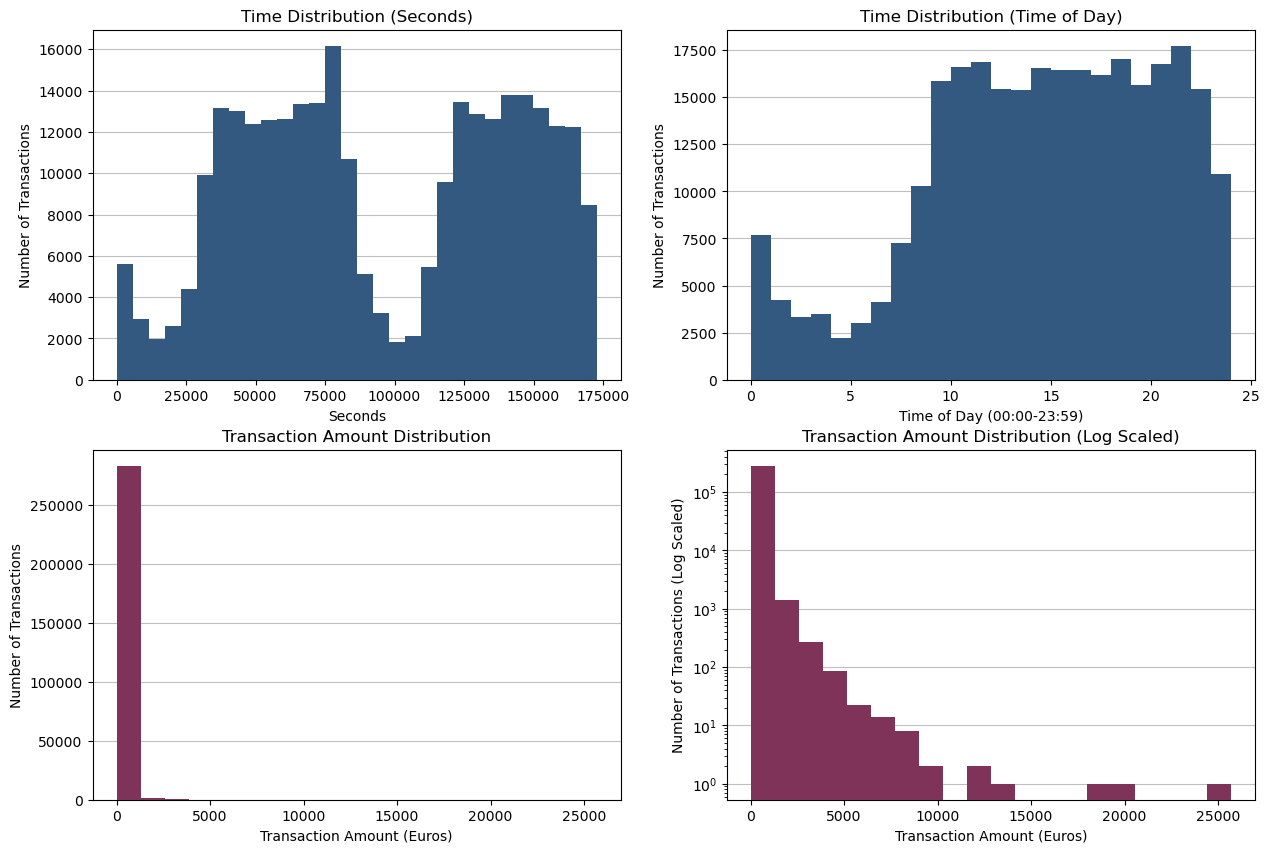

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# seconds histogram
ax1 = df['Time'].plot(kind='hist', bins=30, ax=axes[0][0], color='#335980', zorder=3)
ax1.grid(color='gray', axis='y', alpha=0.5, zorder=1)
ax1.set_title('Time Distribution (Seconds)')
ax1.set_xlabel('Seconds')
ax1.set_ylabel('Number of Transactions')

# convert the seconds to hours for easier interpretation
def convert_seconds(x):
    
    DAY = 86400
    # we assume that 0 seconds marks the start of a new day, 00:00 AM
    hour = x / DAY * 24
    # since the dataset spans two days, convert the second day entries into hour of day
    # eg. if hour = 36, it means 12:00 PM on the second day, so return 12
    if hour >= 24:
        hour = hour - 24
    return hour

df['transaction_time'] = df['Time'].apply(lambda x: convert_seconds(x))

# hours histogram
ax2 = df['transaction_time'].plot(kind='hist', bins=24, ax=axes[0][1], color='#335980', zorder=3)
ax2.grid(color='gray', axis='y', alpha=0.5, zorder=1)
ax2.set_title('Time Distribution (Time of Day)')
ax2.set_xlabel('Time of Day (00:00-23:59)')
ax2.set_ylabel('Number of Transactions')

# transaction amount histogram
ax3 = df['Amount'].plot(kind='hist', bins=20, ax=axes[1][0], color='#803359', zorder=3)
ax3.grid(color='gray', axis='y', alpha=0.5, zorder=1)
ax3.set_title('Transaction Amount Distribution')
ax3.set_xlabel('Transaction Amount (Euros)')
ax3.set_ylabel('Number of Transactions')

# transaction amount histogram log scaled
ax4 = df['Amount'].plot(kind='hist', bins=20, ax=axes[1][1], color='#803359', zorder=3, logy=True)
ax4.grid(color='gray', axis='y', alpha=0.5, zorder=1)
ax4.set_title('Transaction Amount Distribution (Log Scaled)')
ax4.set_xlabel('Transaction Amount (Euros)')
ax4.set_ylabel('Number of Transactions (Log Scaled)')

plt.show()


The top left plot is the distribution of transactions across two days, which is why we see two dips in transaction activity, as those dips are midnight hours when we expect transaction activity to be at its lowest. Thne we see an increase and a gradual plateau. If we look at the top right plot where we converted the seconds into hours of the day, we see on the x-axis a scale from 0 - 24, indicating the time of day. The plateau begins at around 09:00, and ends at 22:00.

The bottom left plot shows the transaction amount distribution, and we see most transactions are within €0 - €1250. There is a large range of transactions, but almost all the transaction amounts are within the €0 - €1250 range. If we use log scaling, we can view the distribution with more clarity. On the bottom right, we see a log scaled distribution of the transaction amounts. We see that the largest transactions make up an insignificant proportion of the total number of transactions.

We will now compare the differences in distributions of fraudulent and non-fraudulent transactions by overlaying them over each other for transaction time and transaction amount respectively.  

In [9]:
# first, compare the aggregate statistics after grouping the classes
df[['Class','transaction_time']].groupby('Class').describe()

transaction_time                                                       \
                 count       mean       std       min        25%        50%   
Class                                                                         
0             284315.0  14.542106  5.844597  0.000000  10.601389  15.014167   
1                492.0  12.136986  6.719614  0.112778   5.923819  12.052361   

                             
             75%        max  
Class                        
0      19.332778  23.999444  
1      17.803681  23.993333

In [10]:
df[['Class','Amount']].groupby('Class').describe()

Amount                                                            
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87

We see that there aren't major differences between the classes for transaction time.

But for transaction amount, we see more differences. For the 25% and 50% quartiles, the transaction amount for fraudulent cases is much lower than non-fraudulent cases, but we see that for the 75% quartile, the transaction amount is much higher than non-fraudulent transactions. We also see that for non-fraudulent transactions, the maximum amount is much larger than for fraudulent transactions. To allow better visualization when plotting, we will remove non-fraudulent transactions (class 0) from our plotting to avoid disproportionately skewing the x-axis.

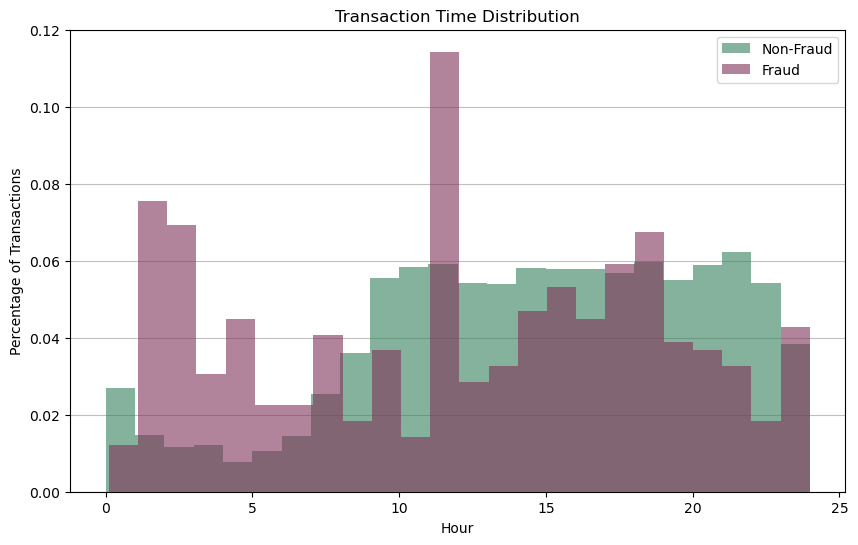

In [11]:
# split the classes
time_0 = df['transaction_time'].loc[df['Class'] == 0]
time_1 = df['transaction_time'].loc[df['Class'] == 1]

# overlay the plots
plt.figure(figsize=(10, 6))

ax = time_0.plot(kind='hist', bins=24, color='#33805a', zorder=3, alpha= 0.6, density=True)
ax = time_1.plot(kind='hist', bins=24, color='#803359', zorder=3, alpha= 0.6, density=True)
ax.grid(color='gray', axis='y', alpha=0.5, zorder=1)
ax.set_title('Transaction Time Distribution')
ax.set_xlabel('Hour')
ax.set_ylabel('Percentage of Transactions')
ax.legend(['Non-Fraud', 'Fraud'])

plt.show()


Our aggregate statistics showed not much difference between the two classes, but when we look at the distribution, we see a larger proportion of fraudlent cases occur during midnight. There is also a spike in fraudulent cases during 12:00. While the non-fraudulent transactions plateau, the fraudulent transactions are more sporadic.

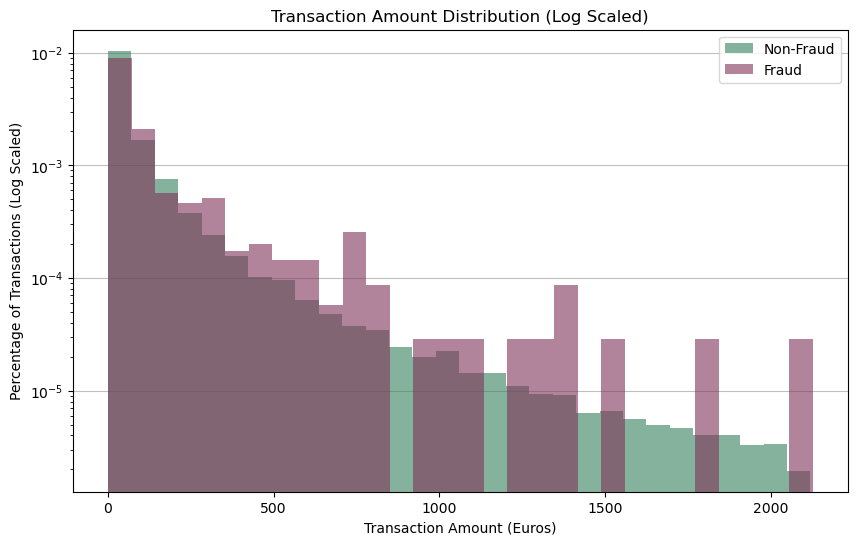

In [12]:
amount_0 = df['Amount'].loc[df['Class'] == 0]
amount_1 = df['Amount'].loc[df['Class'] == 1]

# set the threshold to the maximum amount in class 1
threshold = amount_1.max()

amount_0_filtered = amount_0[amount_0 <= threshold]

# # overlay the plots
plt.figure(figsize=(10, 6))

ax = amount_0_filtered.plot(kind='hist', bins=30, color='#33805a', zorder=3, logy=True, alpha= 0.6, density=True)
ax = amount_1.plot(kind='hist', bins=30, color='#803359', zorder=3, logy=True, alpha= 0.6, density=True)
ax.grid(color='gray', axis='y', alpha=0.5, zorder=1)
ax.set_title('Transaction Amount Distribution (Log Scaled)')
ax.set_xlabel('Transaction Amount (Euros)')
ax.set_ylabel('Percentage of Transactions (Log Scaled)')
ax.legend(['Non-Fraud', 'Fraud'])

plt.show()


In [13]:
amount_0.size


284315

The data for the two classes follow similiar trends, where as the transaction amount increases, there are less transactions. But for fraudulent cases, due to there not being as much data points, we the distribution is not exactly the same as non-fraudulent cases.

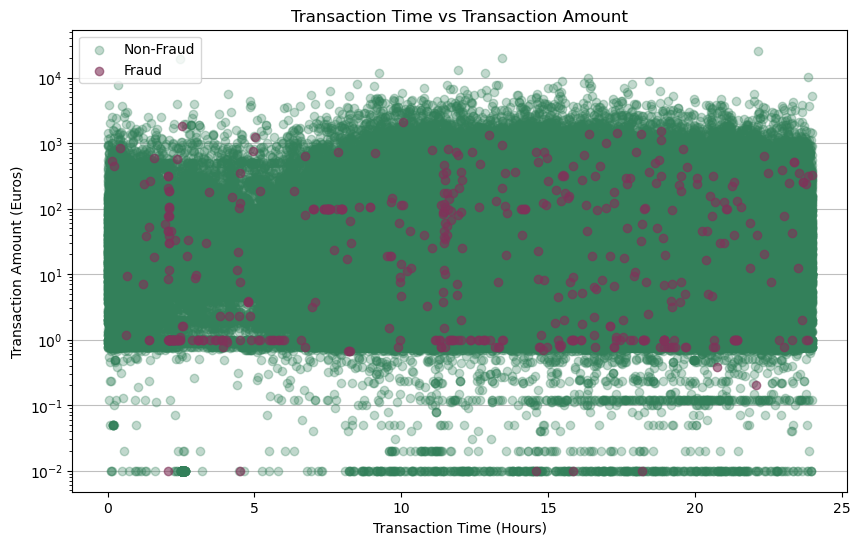

In [14]:
# scatter plot of transaction time vs transaction amount
plt.figure(figsize=(10, 6))
plt.scatter(time_0, amount_0, color='#33805a', zorder=3, alpha= 0.3)
plt.scatter(time_1, amount_1, color='#803359', zorder=3, alpha= 0.6)
plt.yscale('log')
plt.grid(color='gray', axis='y', alpha=0.5, zorder=1)
plt.title('Transaction Time vs Transaction Amount')
plt.xlabel('Transaction Time (Hours)')
plt.ylabel('Transaction Amount (Euros)')
plt.legend(['Non-Fraud', 'Fraud'])

plt.show()


This plot doesn't really help us see the relationship between the two variables, but we see that for non-fraudulent transactions, there is a big green blob, since there are much more non-fraudulent transactions. However, we notice there are some unique insights about the fraudulent transactions in this scatter plot. 

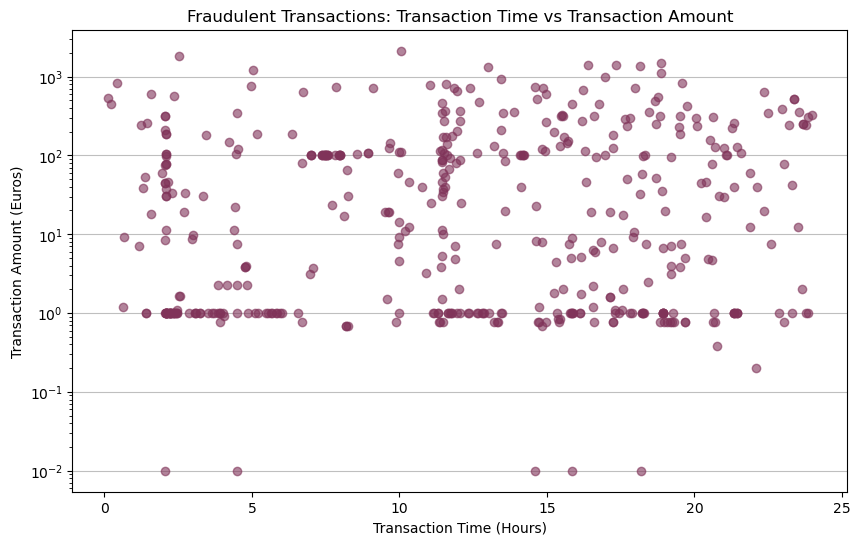

In [15]:
# scatter plot of transaction time vs transaction amount - fraudulent transactions only
plt.figure(figsize=(10, 6))
plt.scatter(time_1, amount_1, color='#803359', zorder=3, alpha= 0.6)
plt.yscale('log')
plt.grid(color='gray', axis='y', alpha=0.5, zorder=1)
plt.title('Fraudulent Transactions: Transaction Time vs Transaction Amount')
plt.xlabel('Transaction Time (Hours)')
plt.ylabel('Transaction Amount (Euros)')

plt.show()


We see that at around 2:00 and 12:00 exactly, there are a number of fraudulent transactions initiated at the same time. This might suggest there are internet bots trying to access payment information at scheduled time intervals. We also see a lot of transactions that are around 1 dollar. This might be done to check if a small payment can be sent through, which might be later followed by a much larger payment.

### Correlation Matrix

Since we have no information on what the PCA transformed features represent, we can run a correlation matrix to see if there are features that might be closely related. A correlation matrix shows the correlation coefficients of all the features. This coefficient tells us how closely a feature is correlated to another feature. A number close to 1 means the features are positively correlated, while a number close to -1 means the features are negatively correlated. A number closer to 0 means that the features have almost no correlation.

There is an issue with seaborn not displaying the correlation matrix correctly, so we update it to a new version. Restart kernal afterwards.

In [16]:
pip install seaborn --upgrade

Note: you may need to restart the kernel to use updated packages.


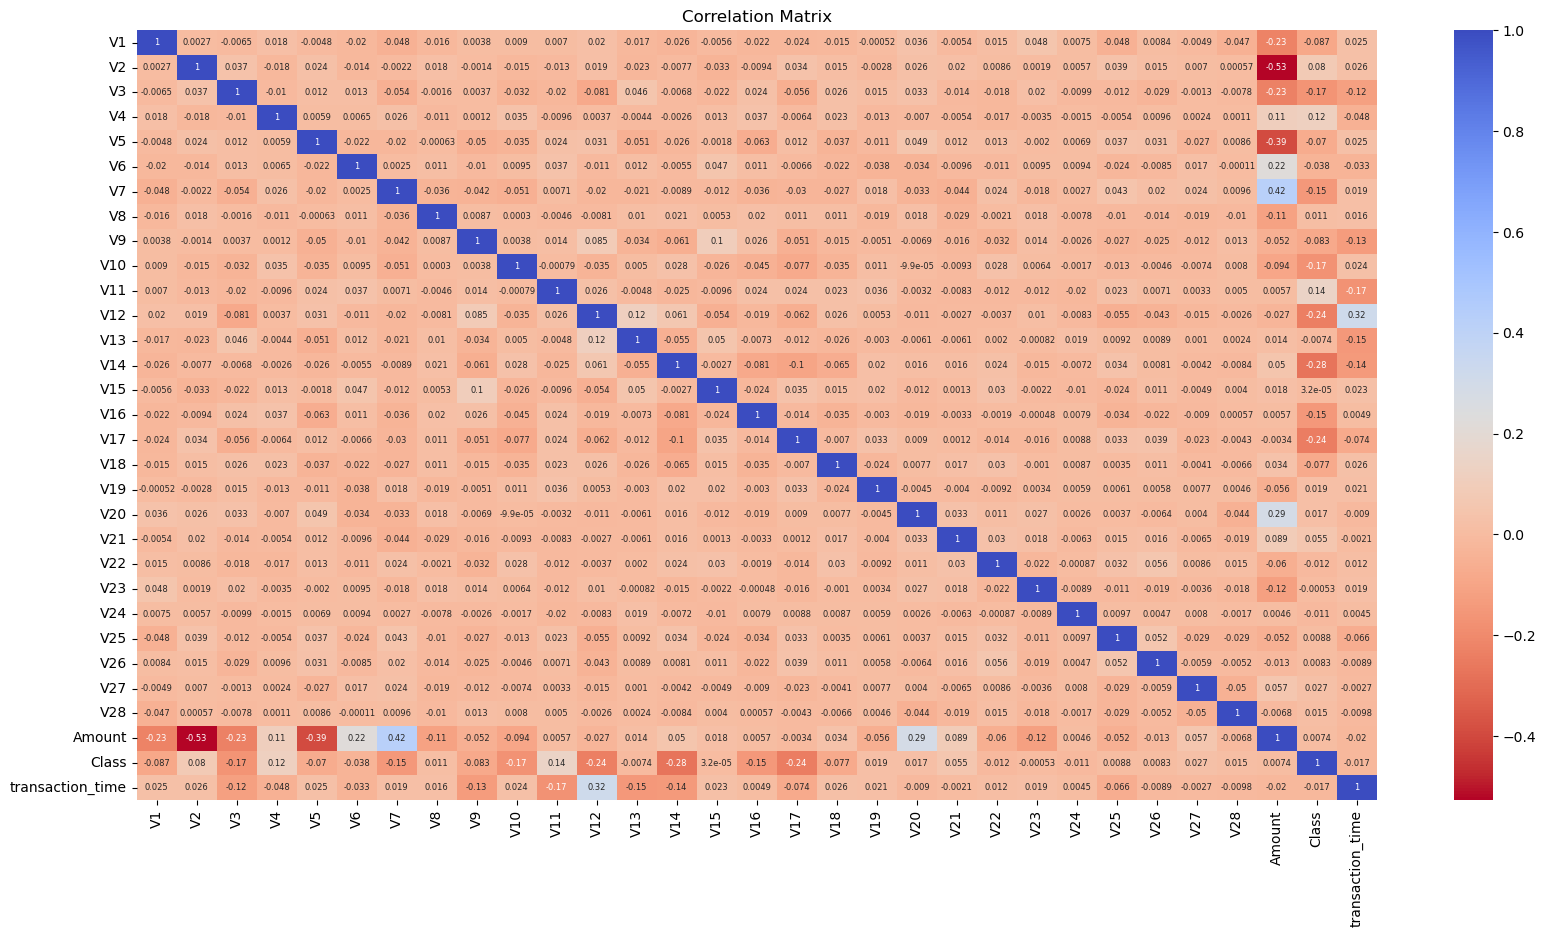

In [21]:
# drop the time column since we already have a new column, transaction_time that tells us the hour of the transaction
df.drop(columns='Time', inplace=True)
corr = df.corr()
plt.figure(figsize=(20, 10))
ax1 = plt.gca()
sns.heatmap(corr, cmap='coolwarm_r', annot=True, annot_kws={'size': 6}, ax=ax1)
ax1.set_title("Correlation Matrix")
plt.show()


We don't see much correlation between the PCA transformed features, but we see some correlation between the transaction amount, transaction time, and class.

**However,** we need to remember our data is heavily skewed towards non-fraud transactions. If one class dominates, the correlation matrix might reflect the characteristics of the dominant class, which can skew the strength of correlation coefficients. So we cannot interpret this correlation matrix as an accurate representation of the actual correlation relationships.

We have reached a point in our analysis where we need to consider data balancing and sampling for future analysis and model training.

## Data Balancing and Sampling

As mentioned above, we need create a balanced dataset to prevent overfitting of our models. To do this, we will have to sample from our negative class (non-fraudulent transactions).